In [1]:
import sys
sys.path.append('/Users/vikram/projects/leela-interp/src')

In [2]:
import itertools
import pickle

import torch
from leela_interp import Lc0sight, LeelaBoard
from leela_interp.tools.attention import attention_attribution, top_k_attributions
from leela_interp.tools.patching import activation_patch

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [3]:
!ls

25877437.zip            interesting_puzzles.pkl opponent.ipynb
LD2.onnx                lc0-random.onnx         pyproject.toml
LICENSE                 lc0.onnx                scripts
README.md               notebooks               src
__init__.py             opponent-Copy1.ipynb    unfiltered_puzzles.pkl


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Lc0sight("lc0.onnx", device=device)

Using device: cpu


In [5]:
with open("interesting_puzzles.pkl", "rb") as f:
    puzzles = pickle.load(f)
len(puzzles)

22517

In [12]:
def find_sacrifice_puzzles(puzzle):
    moves_to_play = [move for i, move in enumerate(puzzle.principal_variation) if i % 2 == 0] 
    squares_to_play_on = [x[2:4] for x in moves_to_play]
    return all(x == squares_to_play_on[0] for x in squares_to_play_on)

sacrifice_puzzles_idx = puzzles.apply(find_sacrifice_puzzles, axis=1)
sacrifice_puzzles = puzzles[sacrifice_puzzles_idx]

In [13]:
sacrifice_puzzles

,PuzzleId,FEN,Moves,Rating,RatingDeviation,Popularity,NbPlays,Themes,GameUrl,OpeningTags,principal_variation,full_pv_probs,full_model_moves,full_wdl,sparring_full_pv_probs,sparring_full_model_moves,sparring_wdl,different_targets,corrupted_fen
182,00Bg4,3r2k1/1q3ppp/p2rp3/Qp1B4/7P/P4P2/1PP3P1/1K1R3R...,d6d5 a5d8 d5d8 d1d8,1374,85,75,303,backRankMate endgame mate mateIn2 short xRayAt...,https://lichess.org/6qWf8wOP/black#41,NaN,"[a5d8, d5d8, d1d8]","[0.9316630959510803, 1.0, 0.9474834203720093]","[a5d8, d5d8, d1d8]","[0.9491999745368958, 0.04444213956594467, 0.00...","[0.008508995175361633, 1.0, 0.772297203540802]","[d1d5, d5d8, d1d8]","[0.007286431733518839, 0.983742892742157, 0.00...",False,3r4/1q3ppp/p3p3/Qp1r4/5k1P/P4P2/1PP3P1/1K1R3R ...
477,00TU2,1k1r4/1p3Qp1/p2q3p/3N4/1b6/8/PP3PPP/2R3K1 w - ...,d5b4 d6d1 c1d1 d8d1,561,81,99,1081,backRankMate endgame mate mateIn2 sacrifice short,https://lichess.org/p32396Rd#42,NaN,"[d6d1, c1d1, d8d1]","[0.9027991890907288, 1.0, 0.9316168427467346]","[d6d1, c1d1, d8d1]","[0.6312634944915771, 0.21408513188362122, 0.15...","[0.019247423857450485, 1.0, 0.33872464299201965]","[d6b4, c1d1, d8d1]","[0.0008122252183966339, 0.996202290058136, 0.0...",False,1k1r4/1p3Qp1/p2q3p/8/1N6/8/PP3PPP/K1R5 b - - 0 22
596,00aBq,r2r2k1/pp3ppp/1qn2b2/3R4/4QB2/1P3N2/P4PPP/4R1K...,d8d5 e4e8 a8e8 e1e8,927,83,88,315,backRankMate mate mateIn2 middlegame sacrifice...,https://lichess.org/0AybhVJm/black#35,Queens_Pawn_Game Queens_Pawn_Game_London_System,"[e4e8, a8e8, e1e8]","[0.8980200290679932, 1.0, 0.7761741876602173]","[e4e8, a8e8, e1e8]","[0.9844181537628174, 0.014828264713287354, 0.0...","[0.008638557977974415, 1.0, 0.15357662737369537]","[e4d5, a8e8, e1e8]","[0.004472474101930857, 0.9796410799026489, 0.0...",False,r1q3k1/pp3ppp/2n2b2/3r4/4QB2/1P3N2/P4PPP/4R1K1...
856,00qMd,4r1kb/3q1p1p/1p1p1PpB/p2P4/2Pp4/6Q1/1P4PP/5RK1...,e8e3 h6e3 d4e3 g3e3,1610,75,83,115,crushing endgame short,https://lichess.org/Q8kfKCl5/black#51,NaN,"[h6e3, d4e3, g3e3]","[0.9296777844429016, 0.8816071152687073, 0.906...","[h6e3, d4e3, g3e3]","[0.9488192796707153, 0.044057901948690414, 0.0...","[0.017292404547333717, 0.8276771306991577, 0.5...","[g3f4, d4e3, g3e3]","[0.018963830545544624, 0.9749616384506226, 0.0...",False,6k1/3q1p1p/1p1p1PpB/p2P4/2Pp4/4r1Q1/1P4PP/2b2R...
863,00r1D,r4k1r/p3nppp/3Qp1b1/8/B7/P1q5/2P2PPP/3R1RK1 b ...,g6c2 d6d8 a8d8 d1d8,1408,94,59,44,backRankMate mate mateIn2 middlegame sacrifice...,https://lichess.org/nb7Z1HHv/black#35,Scandinavian_Defense Scandinavian_Defense_Main...,"[d6d8, a8d8, d1d8]","[0.8163037300109863, 1.0, 0.8381195068359375]","[d6d8, a8d8, d1d8]","[0.9891000390052795, 0.010525636374950409, 0.0...","[0.007367796264588833, 1.0, 0.18417799472808838]","[a4c2, a8d8, d1d8]","[0.0032667804043740034, 0.9905341863632202, 0....",False,r4k1r/p3np1p/3Qp3/8/B7/P1q5/2b2PPP/3R1RK1 w - ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
998475,GROOt,4r1k1/ppp3pp/8/3p3Q/3P4/N1P1q3/PP4PP/R5K1 w - ...,g1h1 e3e1 a1e1 e8e1,1500,500,100,0,backRankMate mate mateIn2 sacrifice short,https://lichess.org/RZmdFKtG#36,NaN,"[e3e1, a1e1, e8e1]","[0.914284348487854, 1.0, 0.9021872282028198]","[e3e1, a1e1, e8e1]","[0.9968218803405762, 0.0031149687711149454, 6....","[0.025426216423511505, 1.0, 0.4032253623008728]","[g7g6, a1e1, e8e1]","[0.0026065187994390726, 0.9903193712234497, 0....",False,4r1k1/ppp3pp/8/3p3Q/3P4/2P1q2N/PP4PP/R6K b - -...
998603,GRWbO,2Q4r/p2rkpp1/1p2p1p1/1Rn1P3/2P5/8/P2q1PPP/R5K1...,c8h8 d2d1 a1d1 d7d1,614,108,77,292,backRankMate endgame mate mateIn2 sacrifice short,https://lichess.org/QNut8GeD#42,NaN,"[d2d1, a1d1, d7d1]","[0.7881166934967041, 1.0, 0.921879768371582]","[d2d1, a1d1, d7d1]","[0.835746705532074, 0.1497642546892166, 0.0144...","[0.004378349520266056, 1.0, 0.7488836050033569]","[d2c3, a1d1, d7d1]","[0.004370738286525011, 0.9921118021011353, 0.0...",False,7Q/p2rkpp1/1p2p1p1/1Rn1P3/2PP4/8/P2q1PPP/R5K1 ...
998727,GRfMQ,r5kr/pp1np2p/2p3pN/3q4/3b4/4BQ2/PPP3PP/R4RK1 b...,g8g7 f3f7 d

Let's look at one of these puzzles:

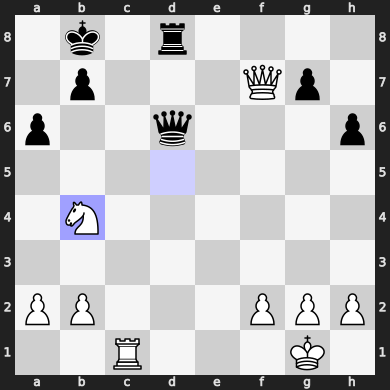

In [14]:
puzzle = sacrifice_puzzles.iloc[1]
board = LeelaBoard.from_puzzle(puzzle)
board

The *principal variation* is the best sequence of moves for both sides:

In [15]:
puzzle.principal_variation

['d6d1', 'c1d1', 'd8d1']

Leela solves this puzzle correctly:

In [16]:
model.pretty_play(board)

Qd1+: 90.28%
a5: 0.97%
Qxb4: 0.58%
Rd7: 0.48%
Ka7: 0.47%
W: 63.13%, D: 21.41%, L: 15.47%


# Visualizing attention patterns

Next, let's look at some attention patterns. These are 64 x 64 arrays, with one entry for each pair of squares.

In [17]:
layer = 9
head = 5

# We're using nnsight to cache activations and do interventions. There's also an interface
# based directly on pytorch hooks if you prefer that, see Lc0Model.capturing().
with model.trace(board):
    attention = model.attention_scores(layer).output[0, head].save()
attention.shape

torch.Size([64, 64])

We can plot slices of this attention pattern:

In [ ]:
square = "b3"
# This converts a square in chess notation to the index inside Leela's activations for
# that square. Note that the input to Leela is flipped depending on the current player's
# color.
idx = board.sq2idx(square)
# attention has shape (query_dim, key_dim); indexing into the first one gives us a slice
# of the attention pattern with fixed query.
board.plot(attention[idx], caption=f"L{layer}H{head} attention with query={square}")

# Attention attribution

Let's look at L12H12 instead and do attention attribution (this is basically approximating a zero-ablation of individual attention weights). We'll then plot the entries with the highest attribution scores as arrows from key to query (i.e. in the direction of information flow).

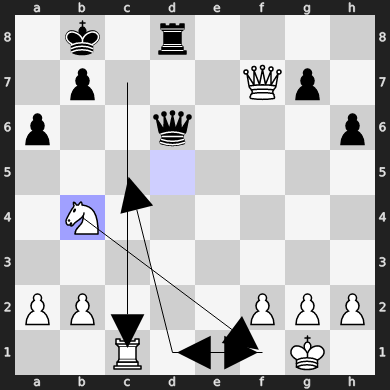

In [18]:
attribution = attention_attribution(
    [board], layer=12, head=12, model=model, return_pt=True
)[0]
values, colors = top_k_attributions(attribution, board, k=5)
board.plot(arrows=colors)

In [ ]:
query_square = puzzle.principal_variation[0][2:4]
key_square = puzzle.principal_variation[2][2:4]
query_idx = board.sq2idx(query_square)
key_idx = board.sq2idx(key_square)

with model.trace(board):
    model.attention_scores(12).output[0, 12, query_idx, key_idx] = 0
    output = model.output.save()

probs = model.logits_to_probs(board, output[0])[0]
policy = model.top_moves(board, probs, top_k=5)
print(policy)
print("WDL:", output[1])

The previous top move, Ng6, is now in 4th place at only 16%. Leela also thinks it's worse (the win probability is down to 9.9% from 28.7%).

# Activation patching

Finally, let's do activation patching. Every puzzle in our dataset already has a "corrupted version" that we automatically generated. This is a very similar board position, but with a slight difference that makes the tactic no longer work. Note the new pawn on h6:

In [ ]:
corrupted_board = LeelaBoard.from_fen(puzzle.corrupted_fen)
display(corrupted_board)
model.pretty_play(corrupted_board)

We could implement activation patching fairly easily with `nnsight`, but we'll instead introduce our patching helper function. Let's patch the output of L12H12 on every square:

In [ ]:
log_odds_reductions = -activation_patch(
    module_func=model.headwise_attention_output,
    # Layer, head, output square:
    locations=list(itertools.product([12], [12], range(64))),
    model=model,
    # We could also pass in board and corrupted_board manually instead
    puzzles=puzzle,
)
log_odds_reductions.shape

In [ ]:
board.plot(log_odds_reductions, caption="Log odds reduction for each square")

As we can see, activation patching essentially only has a big effect on g6, where L12H12 moved information to from h4.

# Next steps
We demonstrated how to use several mechanistic interpretability techniques on a single board position. It's fairly straightforward to extend these to batches of positions, see the files in `scripts` for examples. `nnsight` also makes it quite easy to use other interpretability techniques that we didn't cover here.